In [1]:
%load_ext autoreload
%autoreload 2

# Baseline Completo - Análisis Exhaustivo de Modelos Lineales
## Predicción de Características de Vuelo en Planeador

**Objetivo:** Exploración exhaustiva de modelos lineales con regularización

---

## Contenido

**Parte 1: Modelos Básicos**
1. DummyRegressor (baseline mínimo)
2. LinearRegression 
3. Ridge (α=10)

**Parte 2: Exploración Exhaustiva**  

4. Ridge vs Lasso vs ElasticNet
5. Tuning de alpha (0.001 → 1000)
6. Features simples (14) vs completas (110+)
7. Análisis de feature selection (Lasso)

**Estrategia:**
- Normalización con RobustScaler (crítico)
- Comparación sistemática
- Justificación de decisiones

## 1. Setup

In [40]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score

sys.path.append('../01_Preprocesamiento')
from eda_functions import configurar_visualizacion
from modelo_utils import *

warnings.filterwarnings('ignore')
configurar_visualizacion()
np.random.seed(42)

## 2. Cargar Datos

In [79]:
dev = pd.read_csv('../data/processed/dev.csv', index_col=0)
test = pd.read_csv('../data/processed/test.csv', index_col=0)

targets_reg = [
    'altura_max_m', 'ganancia_altura_m', 'duracion_min', 'distancia_km', 'velocidad_promedio_kmh',
    'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min','tasa_ascenso_mean_ms'
]

print(f"Dev: {dev.shape}, Test: {test.shape}")
print(f"Targets: {len(targets_reg)}")

Dev: (309, 134), Test: (78, 134)
Targets: 9


## 3. Preparar Features + Normalización

Sin normalizar, modelos lineales tienen gaps negativos grandes (Test > Dev) debido a:
- Sensibilidad a escala de features
- Features con rangos muy diferentes (lat/lon vs temp vs viento)

**Solución:** RobustScaler (resistente a outliers)

## Preparacion
Incluye separar en input y target como ademas realizar el tratamiento necesario a las columnas de "lat_despegue", "lon_despegue" y "hora_despegue". 

In [80]:
dev, test = coordenadas_a_one_hot(dev, test)
dev, test = ajustar_hora_despegue(dev, test)

X_dev_simple, y_dev, X_test_simple, y_test = preparar_datos(
    dev, test, targets_reg, modo='simple'
)

# Features COMPLETAS (110 horarias)
X_dev_full, _, X_test_full, _ = preparar_datos(
    dev, test, targets_reg, modo='completo'
)

print(f"Features simples: {X_dev_simple.shape[1]}")
print(f"Features completas: {X_dev_full.shape[1]}")
print(f"Samples: Dev={X_dev_simple.shape[0]}, Test={X_test_simple.shape[0]}")
print(f"\nRatio simple: {X_dev_simple.shape[0]/X_dev_simple.shape[1]:.1f}:1")
print(f"Ratio completo: {X_dev_full.shape[0]/X_dev_full.shape[1]:.1f}:1")

Features simples: 15
Features completas: 125
Samples: Dev=309, Test=78

Ratio simple: 20.6:1
Ratio completo: 2.5:1


## Normalizacion

In [99]:
# Features simples
X_dev_simple_scaled, X_test_simple_scaled, scaler_simple = normalizar_columnas(
    X_dev_simple, X_test_simple, X_dev_simple.columns[4:]  # Normalizar solo las features numéricas
)

# Features completas
X_dev_full_scaled, X_test_full_scaled, scaler_full = normalizar_columnas(
    X_dev_full, X_test_full, X_dev_full.columns[4:]  # Normalizar solo las features numéricas
)

# Guardo el split en data/split para futuros modelos
X_dev_simple_scaled.to_csv('../data/split/X_dev_simple.csv')
X_test_simple_scaled.to_csv('../data/split/X_test_simple.csv')
X_dev_full_scaled.to_csv('../data/split/X_dev_full.csv')
X_test_full_scaled.to_csv('../data/split/X_test_full.csv')
y_dev.to_csv('../data/split/y_dev.csv')
y_test.to_csv('../data/split/y_test.csv')

---
# PARTE 1: Modelos Básicos

Baseline mínimo con features simples

In [82]:
X_dev_full_scaled.head()

,hora_despegue_ajustada,club_2,club_1,club_0,solar_rad_09h,solar_rad_10h,solar_rad_11h,solar_rad_12h,solar_rad_13h,solar_rad_14h,...,precipitation_avg,temp_2m_avg,cloud_cover_avg,wind_u_avg,wind_v_avg,pressure_avg,boundary_layer_height_avg,cape_avg,skin_temp_avg,wind_speed_avg
310,0.628472,0,0,0,0.0,-0.680824,-0.556270,-0.280646,-0.183173,-0.099961,...,0.0,-0.190017,-0.153692,0.521897,0.239152,0.314317,-1.072395,8.627764,-0.476295,-0.597553
59,0.647222,0,1,0,0.0,-0.608752,-0.388326,-0.117755,-0.096339,-0.126853,...,0.0,-1.382035,-0.327317,2.179702,0.143646,-0.622976,-2.456600,0.000000,-1.384446,-1.381540
163,0.720139,0,0,1,0.0,0.393822,0.311155,0.328115,0.218754,0.216713,...,0.0,0.578625,0.116472,-0.490482,-0.614062,-0.800752,1.109244,0.000000,0.614052,0.624557
54,0.675694,0,1,0,0.0,-0.795367,-1.052684,-0.689374,-0.544123,-0.564869,...,0.0,-1.109699,-0.327317,-0.037430,-0.767785,0.079621,-1.448753,0.000000,-1.020633,0.532187
267,0.680556,0,0,1,0.0,0.000000,0.112540,0.202199,0.182017,0.113079,...,0.0,0.148860,-0.110964,-0.209813,0.050227,0.185144,0.252901,0.000000,0.095938,0.000000


In [83]:
X_test_full_scaled.head()

,hora_despegue_ajustada,club_2,club_1,club_0,solar_rad_09h,solar_rad_10h,solar_rad_11h,solar_rad_12h,solar_rad_13h,solar_rad_14h,...,precipitation_avg,temp_2m_avg,cloud_cover_avg,wind_u_avg,wind_v_avg,pressure_avg,boundary_layer_height_avg,cape_avg,skin_temp_avg,wind_speed_avg
48,0.791667,0,1,0,0.0,-0.795367,-1.615632,-1.354097,-1.099422,-1.129739,...,0.000000,-1.882395,-0.324503,0.484307,1.000384,3.187433,-1.115847,0.0,-1.673433,-0.603562
339,0.656944,1,0,0,0.0,-0.795367,-1.826614,-1.690706,-1.378677,-1.508461,...,0.000000,-3.128517,-0.289187,-0.675013,-0.139406,3.826560,-1.666204,0.0,-2.981751,0.337976
257,0.667361,0,0,1,0.0,0.000000,0.112540,0.202199,0.182017,0.113079,...,0.000000,0.148860,-0.110964,-0.209813,0.050227,0.185144,0.252901,0.0,0.095938,0.000000
305,0.635417,0,0,1,0.0,-0.155727,0.007915,0.147568,0.125883,0.169225,...,0.000000,0.576044,-0.327317,-0.246979,0.585811,-1.611812,-0.156153,0.0,0.622567,-0.205089
276,0.723611,0,0,1,0.0,-0.110682,-0.094979,-0.003664,0.000000,-0.160042,...,0.037432,0.027288,1.605088,0.576307,-0.074882,-0.802910,-0.202148,0.0,-0.002059,-0.285622


In [84]:
X_dev_simple_scaled.head()

,hora_despegue_ajustada,club_2,club_1,club_0,solar_rad_avg,precipitation_avg,temp_2m_avg,cloud_cover_avg,wind_u_avg,wind_v_avg,pressure_avg,boundary_layer_height_avg,cape_avg,skin_temp_avg,wind_speed_avg
310,0.628472,0,0,0,0.068051,0.0,-0.190017,-0.153692,0.521897,0.239152,0.314317,-1.072395,8.627764,-0.476295,-0.597553
59,0.647222,0,1,0,-0.088838,0.0,-1.382035,-0.327317,2.179702,0.143646,-0.622976,-2.456600,0.000000,-1.384446,-1.381540
163,0.720139,0,0,1,0.212933,0.0,0.578625,0.116472,-0.490482,-0.614062,-0.800752,1.109244,0.000000,0.614052,0.624557
54,0.675694,0,1,0,-0.377297,0.0,-1.109699,-0.327317,-0.037430,-0.767785,0.079621,-1.448753,0.000000,-1.020633,0.532187
267,0.680556,0,0,1,0.279752,0.0,0.148860,-0.110964,-0.209813,0.050227,0.185144,0.252901,0.000000,0.095938,0.000000


In [85]:
X_test_simple_scaled.head()

,hora_despegue_ajustada,club_2,club_1,club_0,solar_rad_avg,precipitation_avg,temp_2m_avg,cloud_cover_avg,wind_u_avg,wind_v_avg,pressure_avg,boundary_layer_height_avg,cape_avg,skin_temp_avg,wind_speed_avg
48,0.791667,0,1,0,-0.735296,0.000000,-1.882395,-0.324503,0.484307,1.000384,3.187433,-1.115847,0.0,-1.673433,-0.603562
339,0.656944,1,0,0,-0.934658,0.000000,-3.128517,-0.289187,-0.675013,-0.139406,3.826560,-1.666204,0.0,-2.981751,0.337976
257,0.667361,0,0,1,0.279752,0.000000,0.148860,-0.110964,-0.209813,0.050227,0.185144,0.252901,0.0,0.095938,0.000000
305,0.635417,0,0,1,0.265246,0.000000,0.576044,-0.327317,-0.246979,0.585811,-1.611812,-0.156153,0.0,0.622567,-0.205089
276,0.723611,0,0,1,-0.464066,0.037432,0.027288,1.605088,0.576307,-0.074882,-0.802910,-0.202148,0.0,-0.002059,-0.285622


## 4. Modelos Baseline Básicos

In [86]:
# Modelos baseline
modelos_basicos = {
    'DummyRegressor': DummyRegressor,
    'LinearRegression': LinearRegression,
    'Ridge': lambda: Ridge(alpha=10, random_state=42)
}

df_basico, modelos_basico_entrenados = entrenar_baseline(
    X_dev_simple_scaled, y_dev, 
    X_test_simple_scaled, y_test,
    targets_reg,
    modelos_basicos
)

# Clipear R² negativos
df_basico['R2'] = df_basico['R2'].clip(lower=0)


DummyRegressor
altura_max_m:
  Dev:  R² = 0.0000, MAE = 426.25, RMSE = 552.20
  Test: R² = -0.0145, MAE = 429.23, RMSE = 561.10
ganancia_altura_m:
  Dev:  R² = 0.0000, MAE = 408.14, RMSE = 529.87
  Test: R² = -0.0189, MAE = 401.38, RMSE = 526.61
duracion_min:
  Dev:  R² = 0.0000, MAE = 56.09, RMSE = 71.70
  Test: R² = -0.0008, MAE = 55.52, RMSE = 73.23
distancia_km:
  Dev:  R² = 0.0000, MAE = 135.22, RMSE = 170.07
  Test: R² = -0.0001, MAE = 135.33, RMSE = 170.70
velocidad_promedio_kmh:
  Dev:  R² = 0.0000, MAE = 14.68, RMSE = 18.31
  Test: R² = -0.0039, MAE = 14.73, RMSE = 18.86
num_termicas:
  Dev:  R² = 0.0000, MAE = 57.08, RMSE = 69.33
  Test: R² = -0.0035, MAE = 57.12, RMSE = 69.60
intensidad_termicas_mean_ms:
  Dev:  R² = 0.0000, MAE = 0.38, RMSE = 0.55
  Test: R² = -0.0595, MAE = 0.33, RMSE = 0.45
tiempo_en_termicas_min:
  Dev:  R² = 0.0000, MAE = 22.43, RMSE = 28.71
  Test: R² = -0.0010, MAE = 21.94, RMSE = 29.11
tasa_ascenso_mean_ms:
  Dev:  R² = 0.0000, MAE = 0.64, RMSE = 1.

In [87]:
# Tabla comparativa
print("\n" + "="*70)
print("R² en Test Set")
print("="*70)

pivot = df_basico[df_basico['split']=='Test'].pivot(
    index='target', columns='modelo', values='R2'
).sort_values('Ridge', ascending=False)

print(pivot.to_string())

print("\n" + "="*70)
print("Top 3 Targets (Ridge)")
print("="*70)

for target in pivot.head(3).index:
    ridge_r2 = pivot.loc[target, 'Ridge']
    lr_r2 = pivot.loc[target, 'LinearRegression']
    print(f"  {target}:")
    print(f"    Ridge: {ridge_r2:.4f}, LR: {lr_r2:.4f}, Mejora: {ridge_r2-lr_r2:+.4f}")


R² en Test Set
modelo                       DummyRegressor  LinearRegression     Ridge
target                                                                 
velocidad_promedio_kmh                  0.0          0.468953  0.450684
distancia_km                            0.0          0.646962  0.403966
altura_max_m                            0.0          0.450947  0.384892
tiempo_en_termicas_min                  0.0          0.626433  0.353928
duracion_min                            0.0          0.670992  0.304740
ganancia_altura_m                       0.0          0.375309  0.303496
num_termicas                            0.0          0.155922  0.130882
tasa_ascenso_mean_ms                    0.0          0.000000  0.003937
intensidad_termicas_mean_ms             0.0          0.000000  0.000000

Top 3 Targets (Ridge)
  velocidad_promedio_kmh:
    Ridge: 0.4507, LR: 0.4690, Mejora: -0.0183
  distancia_km:
    Ridge: 0.4040, LR: 0.6470, Mejora: -0.2430
  altura_max_m:
    Ridge: 0.3849

---
# PARTE 2: Exploración Exhaustiva

Ridge vs Lasso vs ElasticNet con tuning

## 5. Grid de Alphas

In [88]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

print("Alphas a explorar:")
print(alphas)
print(f"\nCombinaciones: {len(alphas)} alphas × 3 modelos × 2 configuraciones")

Alphas a explorar:
[0.001, 0.01, 0.1, 1, 10, 100, 1000]

Combinaciones: 7 alphas × 3 modelos × 2 configuraciones


## 6. Tuning - Features SIMPLES (14)

In [89]:
modelos = {
    'LinearRegression': LinearRegression,
    'Ridge': Ridge,
    'Lasso': Lasso,
    'ElasticNet': ElasticNet
}

resultados_simple = []
mejores_modelos_simple = {}

print("="*70)
print("TUNING - FEATURES SIMPLES (14)")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    mejores_modelos_simple[target] = {}
    
    for nombre_modelo, ModelClass in modelos.items():
        
        # LinearRegression no tiene alpha
        if nombre_modelo == 'LinearRegression':
            modelo = ModelClass()
            modelo.fit(X_dev_simple_scaled, y_dev[target])
            
            y_pred_dev = modelo.predict(X_dev_simple_scaled)
            y_pred_test = modelo.predict(X_test_simple_scaled)
            
            cv_scores = cross_val_score(modelo, X_dev_simple_scaled, y_dev[target],
                                       cv=5, scoring='r2', n_jobs=1)
            r2_cv = cv_scores.mean()
            r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
            r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
            best_alpha = None
            
        else:
            # Ridge, Lasso, ElasticNet con tuning
            param_grid = {'alpha': alphas}
            
            grid = GridSearchCV(
                ModelClass(random_state=42),
                param_grid,
                cv=5,
                scoring='r2',
                n_jobs=1
            )
            
            grid.fit(X_dev_simple_scaled, y_dev[target])
            modelo = grid.best_estimator_
            
            y_pred_dev = grid.predict(X_dev_simple_scaled)
            y_pred_test = grid.predict(X_test_simple_scaled)
            
            r2_cv = grid.best_score_
            r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
            r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
            best_alpha = grid.best_params_['alpha']
        
        resultados_simple.append({
            'target': target,
            'modelo': nombre_modelo,
            'features': 'simple',
            'n_features': X_dev_simple_scaled.shape[1],
            'alpha': best_alpha,
            'CV_R2': r2_cv,
            'Dev_R2': r2_dev,
            'Test_R2': r2_test,
            'Gap': r2_dev - r2_test
        })
        
        mejores_modelos_simple[target][nombre_modelo] = modelo
        
        if best_alpha is not None:
            print(f"  {nombre_modelo:18s}: CV={r2_cv:.4f}, Test={r2_test:.4f}, alpha={best_alpha:7.3f}")
        else:
            print(f"  {nombre_modelo:18s}: CV={r2_cv:.4f}, Test={r2_test:.4f}")

df_simple = pd.DataFrame(resultados_simple)
# NO clipear - mostrar R² negativos en gráficos
print("\n" + "="*70)

TUNING - FEATURES SIMPLES (14)

altura_max_m:
  LinearRegression  : CV=0.2578, Test=0.4509
  Ridge             : CV=0.2861, Test=0.4534, alpha=  0.100
  Lasso             : CV=0.2858, Test=0.4508, alpha=  1.000
  ElasticNet        : CV=0.2852, Test=0.4508, alpha=  0.001

ganancia_altura_m:
  LinearRegression  : CV=0.2034, Test=0.3753
  Ridge             : CV=0.2343, Test=0.3777, alpha=  0.100
  Lasso             : CV=0.2322, Test=0.3743, alpha=  1.000
  ElasticNet        : CV=0.2333, Test=0.3747, alpha=  0.001

duracion_min:
  LinearRegression  : CV=0.3622, Test=0.6710
  Ridge             : CV=0.3771, Test=0.6712, alpha=  0.010
  Lasso             : CV=0.3988, Test=0.6715, alpha=  0.100
  ElasticNet        : CV=0.3623, Test=0.6241, alpha=  0.001

distancia_km:
  LinearRegression  : CV=0.3282, Test=0.6470
  Ridge             : CV=0.3645, Test=0.6317, alpha=  0.100
  Lasso             : CV=0.3647, Test=0.6479, alpha=  0.100
  ElasticNet        : CV=0.3591, Test=0.6171, alpha=  0.001

vel

## 7. Tuning - Features COMPLETAS (110+)

In [90]:
resultados_full = []
mejores_modelos_full = {}

print("="*70)
print("TUNING - FEATURES COMPLETAS (110+)")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    mejores_modelos_full[target] = {}
    
    for nombre_modelo, ModelClass in modelos.items():
        
        # LinearRegression no tiene alpha
        if nombre_modelo == 'LinearRegression':
            modelo = ModelClass()
            modelo.fit(X_dev_full_scaled, y_dev[target])
            
            y_pred_dev = modelo.predict(X_dev_full_scaled)
            y_pred_test = modelo.predict(X_test_full_scaled)
            
            cv_scores = cross_val_score(modelo, X_dev_full_scaled, y_dev[target],
                                       cv=5, scoring='r2', n_jobs=1)
            r2_cv = cv_scores.mean()
            r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
            r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
            best_alpha = None
            
        else:
            # Ridge, Lasso, ElasticNet con tuning
            param_grid = {'alpha': alphas}
            
            grid = GridSearchCV(
                ModelClass(random_state=42),
                param_grid,
                cv=5,
                scoring='r2',
                n_jobs=1
            )
            
            grid.fit(X_dev_full_scaled, y_dev[target])
            modelo = grid.best_estimator_
            
            y_pred_dev = grid.predict(X_dev_full_scaled)
            y_pred_test = grid.predict(X_test_full_scaled)
            
            r2_cv = grid.best_score_
            r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
            r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
            best_alpha = grid.best_params_['alpha']
        
        resultados_full.append({
            'target': target,
            'modelo': nombre_modelo,
            'features': 'full',
            'n_features': X_dev_full_scaled.shape[1],
            'alpha': best_alpha,
            'CV_R2': r2_cv,
            'Dev_R2': r2_dev,
            'Test_R2': r2_test,
            'Gap': r2_dev - r2_test
        })
        
        mejores_modelos_full[target][nombre_modelo] = modelo
        
        if best_alpha is not None:
            print(f"  {nombre_modelo:18s}: CV={r2_cv:.4f}, Test={r2_test:.4f}, alpha={best_alpha:7.3f}")
        else:
            print(f"  {nombre_modelo:18s}: CV={r2_cv:.4f}, Test={r2_test:.4f}")

df_full = pd.DataFrame(resultados_full)
# clipear - mostrar R² negativos en gráficos
df_full['Test_R2'] = df_full['Test_R2'].clip(lower=0)

print("\n" + "="*70)

TUNING - FEATURES COMPLETAS (110+)

altura_max_m:
  LinearRegression  : CV=-2.0132, Test=0.5852
  Ridge             : CV=0.4289, Test=0.6070, alpha=  1.000
  Lasso             : CV=0.4597, Test=0.6048, alpha=  1.000
  ElasticNet        : CV=0.4398, Test=0.5846, alpha=  0.010

ganancia_altura_m:
  LinearRegression  : CV=-2.2306, Test=0.5274
  Ridge             : CV=0.3894, Test=0.5506, alpha=  1.000
  Lasso             : CV=0.4184, Test=0.5491, alpha=  1.000
  ElasticNet        : CV=0.4010, Test=0.5255, alpha=  0.010

duracion_min:
  LinearRegression  : CV=-5.1613, Test=-0.1300
  Ridge             : CV=0.2018, Test=0.3982, alpha= 10.000
  Lasso             : CV=0.4260, Test=0.6985, alpha=  0.100
  ElasticNet        : CV=0.2482, Test=0.4799, alpha=  0.010

distancia_km:
  LinearRegression  : CV=-4.9482, Test=0.2494
  Ridge             : CV=0.2879, Test=0.5366, alpha= 10.000
  Lasso             : CV=0.3449, Test=0.6567, alpha=  1.000
  ElasticNet        : CV=0.3215, Test=0.5952, alpha=  0

## 8. Comparaciones

In [91]:
# Combinar resultados
df_todos = pd.concat([df_simple, df_full], ignore_index=True)

print("="*70)
print("COMPARACIÓN: Features Simples vs Completas")
print("="*70)

for target in targets_reg:
    best_simple = df_simple[df_simple['target']==target].nlargest(1, 'Test_R2').iloc[0]
    best_full = df_full[df_full['target']==target].nlargest(1, 'Test_R2').iloc[0]
    
    print(f"\n{target}:")
    print(f"  Simple: {best_simple['modelo']:12s} R²={best_simple['Test_R2']:.4f} (α={best_simple['alpha']:7.3f})")
    print(f"  Full:   {best_full['modelo']:12s} R²={best_full['Test_R2']:.4f} (α={best_full['alpha']:7.3f})")
    
    if best_simple['Test_R2'] > best_full['Test_R2']:
        print(f"  ✓ SIMPLE mejor ({best_simple['Test_R2'] - best_full['Test_R2']:+.4f})")
    else:
        print(f"  ✓ FULL mejor ({best_full['Test_R2'] - best_simple['Test_R2']:+.4f})")

print("\n" + "="*70)

COMPARACIÓN: Features Simples vs Completas

altura_max_m:
  Simple: Ridge        R²=0.4534 (α=  0.100)
  Full:   Ridge        R²=0.6070 (α=  1.000)
  ✓ FULL mejor (+0.1536)

ganancia_altura_m:
  Simple: Ridge        R²=0.3777 (α=  0.100)
  Full:   Ridge        R²=0.5506 (α=  1.000)
  ✓ FULL mejor (+0.1729)

duracion_min:
  Simple: Lasso        R²=0.6715 (α=  0.100)
  Full:   Lasso        R²=0.6985 (α=  0.100)
  ✓ FULL mejor (+0.0270)

distancia_km:
  Simple: Lasso        R²=0.6479 (α=  0.100)
  Full:   Lasso        R²=0.6567 (α=  1.000)
  ✓ FULL mejor (+0.0088)

velocidad_promedio_kmh:
  Simple: LinearRegression R²=0.4690 (α=    nan)
  Full:   ElasticNet   R²=0.4824 (α=  0.100)
  ✓ FULL mejor (+0.0135)

num_termicas:
  Simple: Lasso        R²=0.1697 (α=  0.100)
  Full:   ElasticNet   R²=0.1560 (α=  1.000)
  ✓ SIMPLE mejor (+0.0137)

intensidad_termicas_mean_ms:
  Simple: Ridge        R²=-0.0530 (α=1000.000)
  Full:   LinearRegression R²=0.0000 (α=    nan)
  ✓ FULL mejor (+0.0530)

tiem

In [92]:
print("="*70)
print("COMPARACIÓN: Todos los Modelos (Features Simples)")
print("="*70)

resumen_modelos = df_simple.groupby('modelo')['Test_R2'].agg(['mean', 'std', 'max', 'min'])
print("\n" + resumen_modelos.to_string())

print("\n" + "="*70)
print("GANADOR POR TARGET:")
print("="*70)

ganadores = df_simple.loc[df_simple.groupby('target')['Test_R2'].idxmax()]
conteo = ganadores['modelo'].value_counts()
print("\n" + conteo.to_string())

modelo_ganador_simple = conteo.idxmax()
print(f"\n✓ MODELO GANADOR (Features Simples): {modelo_ganador_simple}")

print("\n" + "="*70)
print("COMPARACIÓN: Todos los Modelos (Features Completas)")
print("="*70)

resumen_modelos_full = df_full.groupby('modelo')['Test_R2'].agg(['mean', 'std', 'max', 'min'])
print("\n" + resumen_modelos_full.to_string())

ganadores_full = df_full.loc[df_full.groupby('target')['Test_R2'].idxmax()]
conteo_full = ganadores_full['modelo'].value_counts()
print("\n" + "="*70)
print("GANADOR POR TARGET (Features Completas):")
print("="*70)
print("\n" + conteo_full.to_string())

modelo_ganador_full = conteo_full.idxmax()
print(f"\n✓ MODELO GANADOR (Features Completas): {modelo_ganador_full}")

COMPARACIÓN: Todos los Modelos (Features Simples)

                      mean       std       max       min
modelo                                                  
ElasticNet        0.352784  0.269486  0.624148 -0.059496
Lasso             0.367831  0.282341  0.671500 -0.059496
LinearRegression  0.360472  0.294151  0.670992 -0.092544
Ridge             0.365593  0.278755  0.671198 -0.053037

GANADOR POR TARGET:

modelo
Ridge               5
Lasso               3
LinearRegression    1

✓ MODELO GANADOR (Features Simples): Ridge

COMPARACIÓN: Todos los Modelos (Features Completas)

                      mean       std       max  min
modelo                                             
ElasticNet        0.375091  0.249547  0.595230  0.0
Lasso             0.421208  0.295657  0.714429  0.0
LinearRegression  0.180592  0.236627  0.585175  0.0
Ridge             0.350743  0.237354  0.606952  0.0

GANADOR POR TARGET (Features Completas):

modelo
Lasso               3
Ridge               2
LinearRe

## 9. Feature Selection (Lasso)

In [93]:
print("="*70)
print("FEATURE SELECTION: Lasso con Features Completas")
print("="*70)

target_ejemplo = 'distancia_km'
lasso_model = mejores_modelos_full[target_ejemplo]['Lasso']

coefs = pd.DataFrame({
    'feature': X_dev_full_scaled.columns,
    'coef': lasso_model.coef_
}).sort_values('coef', key=abs, ascending=False)

features_seleccionadas = coefs[coefs['coef'] != 0]
features_eliminadas = coefs[coefs['coef'] == 0]

print(f"\n{target_ejemplo}:")
print(f"  Features totales: {len(coefs)}")
print(f"  Features seleccionadas: {len(features_seleccionadas)}")
print(f"  Features eliminadas: {len(features_eliminadas)}")

print(f"\n  Top 10 features más importantes:")
for _, row in features_seleccionadas.head(10).iterrows():
    print(f"    {row['feature']:30s}: {row['coef']:8.4f}")

print("\n" + "="*70)

FEATURE SELECTION: Lasso con Features Completas

distancia_km:
  Features totales: 125
  Features seleccionadas: 41
  Features eliminadas: 84

  Top 10 features más importantes:
    hora_despegue_ajustada        : -766.4123
    wind_v_16h                    : -102.0777
    club_2                        : -80.8876
    wind_v_18h                    :  76.8055
    skin_temp_16h                 : -71.6223
    wind_speed_18h                : -53.3884
    boundary_layer_height_17h     :  47.6991
    temp_2m_10h                   :  38.8084
    boundary_layer_height_18h     :  37.9524
    pressure_10h                  :  34.5495



## 10. Visualizaciones

Verificando orden de targets:
['altura_max_m', 'ganancia_altura_m', 'duracion_min', 'distancia_km', 'velocidad_promedio_kmh', 'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min', 'tasa_ascenso_mean_ms']

R² de LinearRegression por target:
target
altura_max_m                   0.450947
ganancia_altura_m              0.375309
duracion_min                   0.670992
distancia_km                   0.646962
velocidad_promedio_kmh         0.468953
num_termicas                   0.155922
intensidad_termicas_mean_ms   -0.092544
tiempo_en_termicas_min         0.626433
tasa_ascenso_mean_ms          -0.058727
Name: LinearRegression, dtype: float64


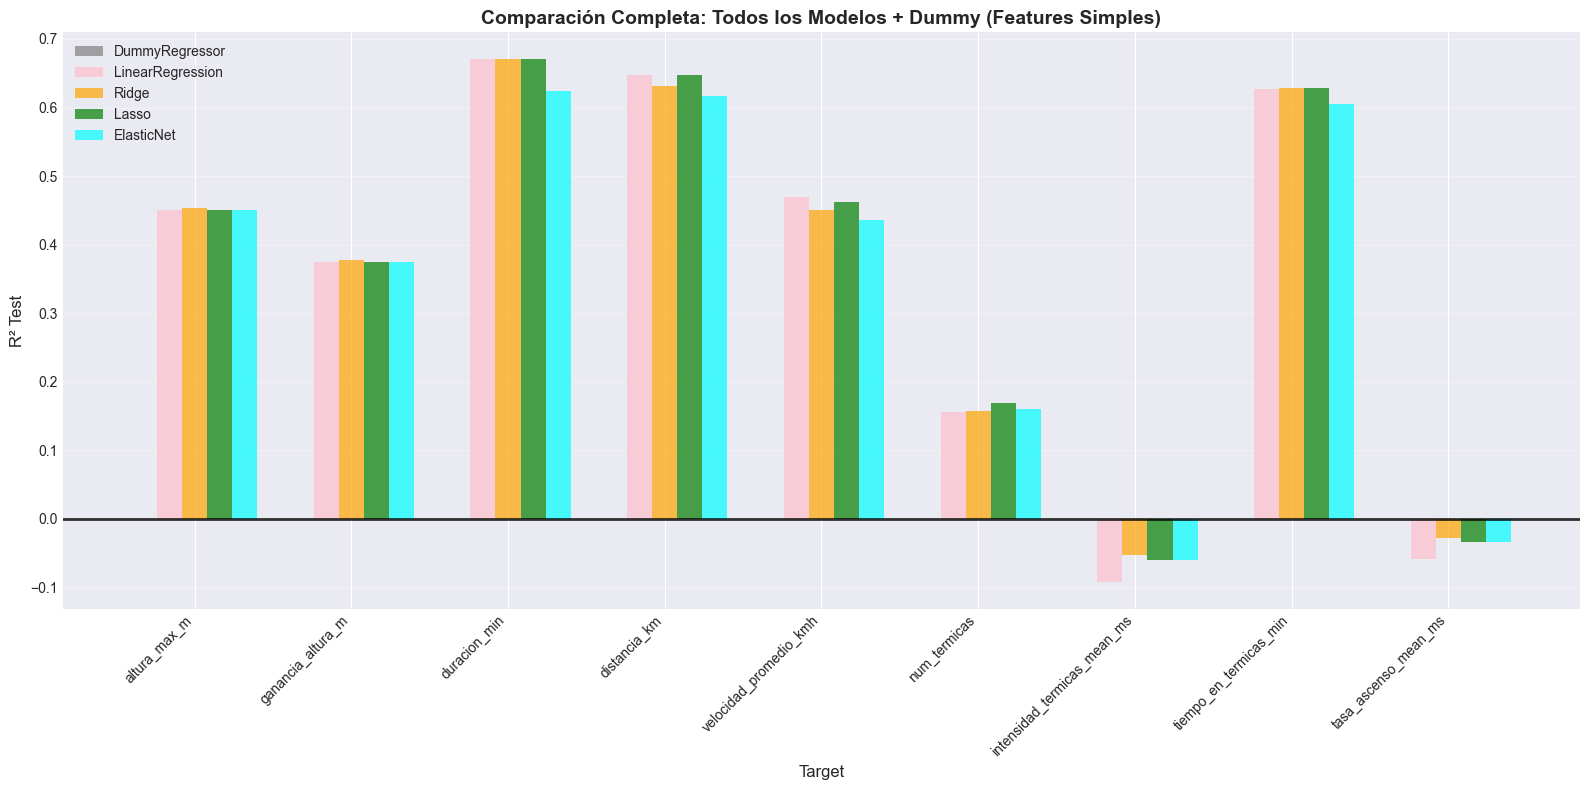

In [94]:
# Gráfico 1: Todos los modelos incluyendo Dummy (Features Simples)
fig, ax = plt.subplots(figsize=(16, 8))

# Combinar df_basico (Dummy) con df_simple
df_dummy_simple = df_basico[df_basico['modelo']=='DummyRegressor'][['target', 'R2', 'split']].copy()
df_dummy_simple = df_dummy_simple[df_dummy_simple['split']=='Test'].copy()
df_dummy_simple = df_dummy_simple.rename(columns={'R2': 'Test_R2'})
df_dummy_simple['modelo'] = 'DummyRegressor'

# Crear pivot incluyendo Dummy
df_todos_simple = pd.concat([
    df_dummy_simple[['target', 'modelo', 'Test_R2']],
    df_simple[['target', 'modelo', 'Test_R2']]
])
df_pivot = df_todos_simple.pivot(index='target', columns='modelo', values='Test_R2')

# CRÍTICO: Reordenar según targets_reg
df_pivot = df_pivot.reindex(targets_reg)

print("Verificando orden de targets:")
print(df_pivot.index.tolist())
print("\nR² de LinearRegression por target:")
print(df_pivot['LinearRegression'])

x = np.arange(len(targets_reg))
width = 0.16

modelos_lista_completa = ['DummyRegressor', 'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']
colors = ['gray', 'pink', 'orange', 'green', 'cyan']

for i, (modelo, color) in enumerate(zip(modelos_lista_completa, colors)):
    offset = (i - 2) * width
    valores = df_pivot[modelo].values
    
    bars = ax.bar(x + offset, valores, width, label=modelo, color=color, alpha=0.7)

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Test', fontsize=12)
ax.set_title('Comparación Completa: Todos los Modelos + Dummy (Features Simples)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=10, loc='upper left')
ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.8)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/baseline_todos_simple.png', dpi=300, bbox_inches='tight')
plt.show()


Verificando orden de targets (features completas):
['altura_max_m', 'ganancia_altura_m', 'duracion_min', 'distancia_km', 'velocidad_promedio_kmh', 'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min', 'tasa_ascenso_mean_ms']


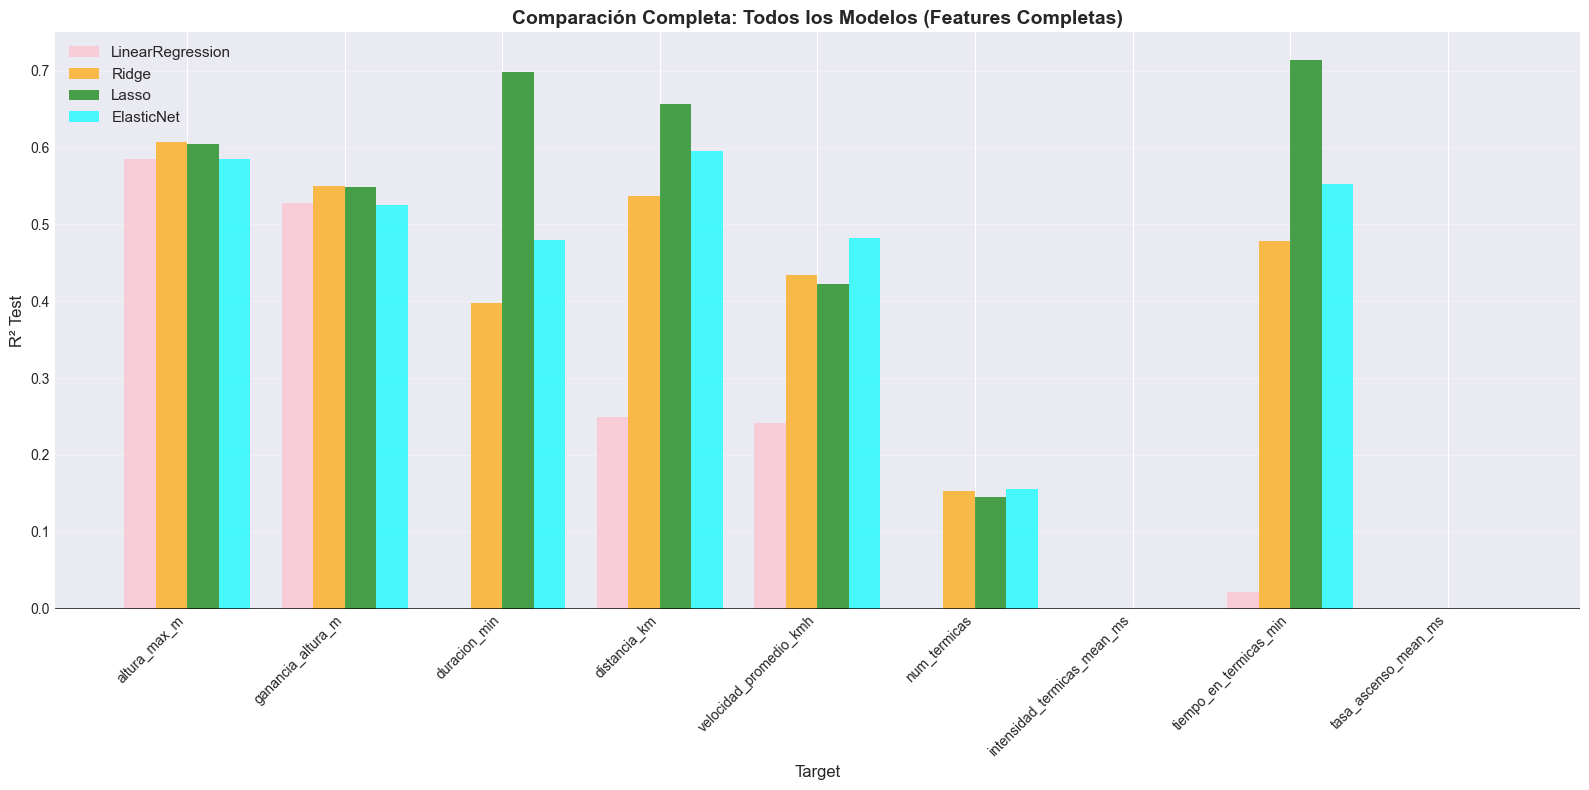

In [95]:
# Gráfico 1b: Todos los modelos (Features Completas)
fig, ax = plt.subplots(figsize=(16, 8))

df_pivot_full = df_full.pivot(index='target', columns='modelo', values='Test_R2')

# CRÍTICO: Reordenar según targets_reg
df_pivot_full = df_pivot_full.reindex(targets_reg)

print("\nVerificando orden de targets (features completas):")
print(df_pivot_full.index.tolist())

x = np.arange(len(targets_reg))
width = 0.2

modelos_lista = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']
colors = ['pink', 'orange', 'green', 'cyan']

for i, (modelo, color) in enumerate(zip(modelos_lista, colors)):
    offset = (i - 1.5) * width
    valores = df_pivot_full[modelo].values
    
    bars = ax.bar(x + offset, valores, width, label=modelo, color=color, alpha=0.7)
    

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Test', fontsize=12)
ax.set_title('Comparación Completa: Todos los Modelos (Features Completas)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11, loc='upper left')
ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.8)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/baseline_todos_full.png', dpi=300, bbox_inches='tight')
plt.show()

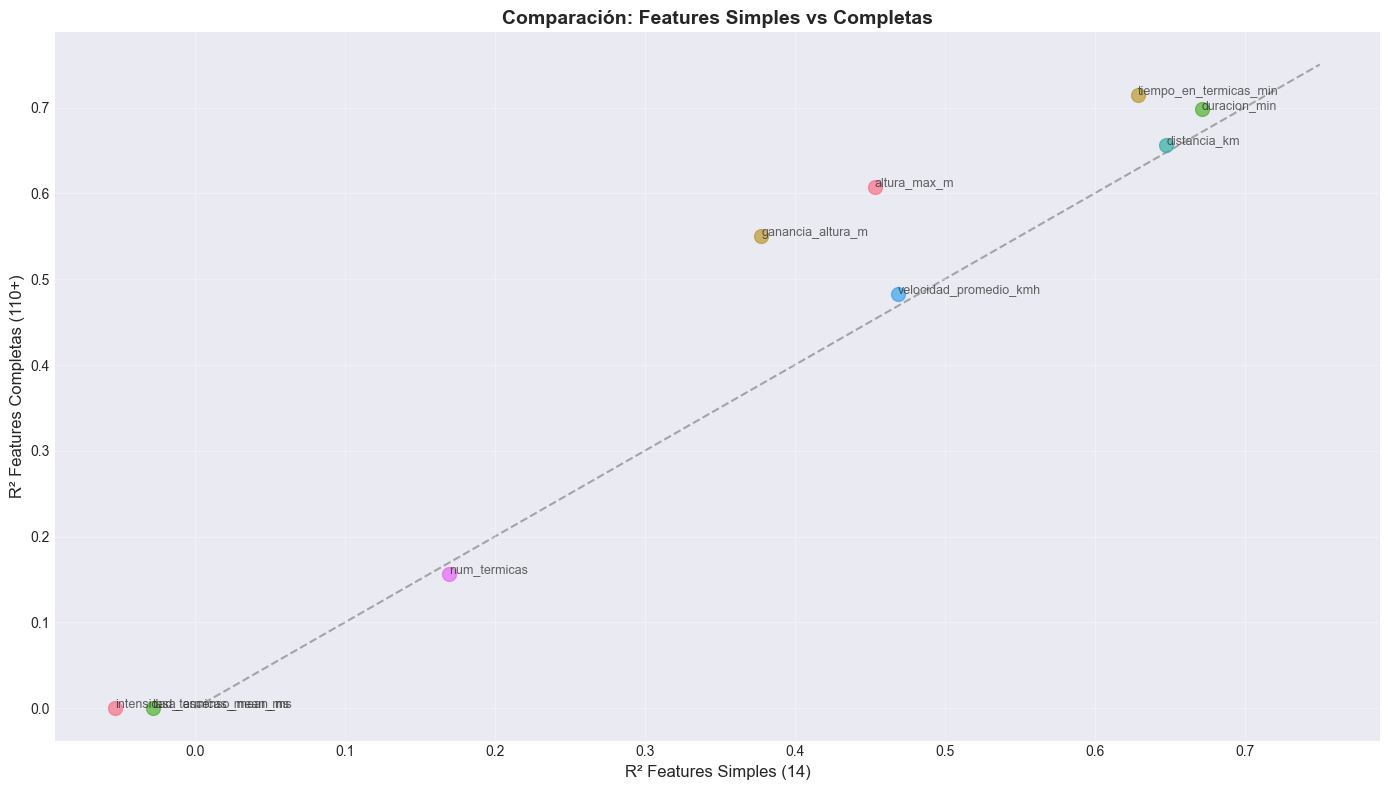

In [96]:
# Gráfico 2: Simple vs Full
fig, ax = plt.subplots(figsize=(14, 8))

for target in targets_reg:
    best_simple = df_simple[df_simple['target']==target]['Test_R2'].max()
    best_full = df_full[df_full['target']==target]['Test_R2'].max()
    
    ax.scatter(best_simple, best_full, s=100, alpha=0.7)
    ax.annotate(target, (best_simple, best_full), fontsize=9, alpha=0.7)

lims = [0, max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.3, zorder=0)

ax.set_xlabel('R² Features Simples (14)', fontsize=12)
ax.set_ylabel('R² Features Completas (110+)', fontsize=12)
ax.set_title('Comparación: Features Simples vs Completas', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/baseline_simple_vs_full.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Recomendación Final

In [97]:
print("="*70)
print("RECOMENDACIÓN FINAL - BASELINE")
print("="*70)

mejor_config_simple = df_simple.groupby('modelo')['Test_R2'].mean().idxmax()
mejor_config_full = df_full.groupby('modelo')['Test_R2'].mean().idxmax()

r2_promedio_simple = df_simple[df_simple['modelo']==mejor_config_simple]['Test_R2'].mean()
r2_promedio_full = df_full[df_full['modelo']==mejor_config_full]['Test_R2'].mean()

print(f"\nMejor modelo con features SIMPLES:")
print(f"  Modelo: {mejor_config_simple}")
print(f"  R² promedio: {r2_promedio_simple:.4f}")
print(f"  Features: 14 promedios meteorológicos")

print(f"\nMejor modelo con features COMPLETAS:")
print(f"  Modelo: {mejor_config_full}")
print(f"  R² promedio: {r2_promedio_full:.4f}")
print(f"  Features: 110+ horarias")

print("\n" + "="*70)
print("CONCLUSIÓN:")
print("="*70)

if r2_promedio_simple > r2_promedio_full:
    print(f"\n✓ USAR: {mejor_config_simple} con features SIMPLES")
    print(f"\nRazones:")
    print(f"  1. Mejor R² promedio ({r2_promedio_simple:.4f} vs {r2_promedio_full:.4f})")
    print(f"  2. Ratio samples/features saludable (22:1)")
    print(f"  3. Menor riesgo de overfitting")
    print(f"  4. Más interpretable")
else:
    print(f"\n✓ USAR: {mejor_config_full} con features COMPLETAS")
    print(f"\nRazones:")
    print(f"  1. Mejor R² promedio ({r2_promedio_full:.4f} vs {r2_promedio_simple:.4f})")
    print(f"  2. Captura evolución temporal horaria")
    print(f"  3. Regularización controla overfitting")

print("\n" + "="*70)

# Top 5 targets
print("\nTop 5 Targets (Mejor configuración):")
top_config = df_full if r2_promedio_full > r2_promedio_simple else df_simple
top5 = top_config.groupby('target')['Test_R2'].max().nlargest(5)
for i, (target, r2) in enumerate(top5.items(), 1):
    print(f"  {i}. {target:30s}: R² = {r2:.4f}")

RECOMENDACIÓN FINAL - BASELINE

Mejor modelo con features SIMPLES:
  Modelo: Lasso
  R² promedio: 0.3678
  Features: 14 promedios meteorológicos

Mejor modelo con features COMPLETAS:
  Modelo: Lasso
  R² promedio: 0.4212
  Features: 110+ horarias

CONCLUSIÓN:

✓ USAR: Lasso con features COMPLETAS

Razones:
  1. Mejor R² promedio (0.4212 vs 0.3678)
  2. Captura evolución temporal horaria
  3. Regularización controla overfitting


Top 5 Targets (Mejor configuración):
  1. tiempo_en_termicas_min        : R² = 0.7144
  2. duracion_min                  : R² = 0.6985
  3. distancia_km                  : R² = 0.6567
  4. altura_max_m                  : R² = 0.6070
  5. ganancia_altura_m             : R² = 0.5506


## 12. Guardar Resultados

In [98]:
# Guardar resultados
df_basico.to_csv('../data/processed/baseline_basico.csv', index=False)
df_todos.to_csv('../data/processed/baseline_completo.csv', index=False)

print("\n" + "="*70)
print("ARCHIVOS GUARDADOS")
print("="*70)
print("  - data/processed/baseline_basico.csv")
print("  - data/processed/baseline_completo.csv")
print("  - data/processed/baseline_todos_simple.png")
print("  - data/processed/baseline_todos_full.png")
print("  - data/processed/baseline_simple_vs_full.png")
print("\n" + "="*70)
print("✓ BASELINE COMPLETO FINALIZADO")
print("  - Comparación exhaustiva: Linear, Ridge, Lasso, ElasticNet")
print("  - Features simples vs completas")
print("  - Normalización aplicada")
print("  - Tuning de hiperparámetros")
print("="*70)


ARCHIVOS GUARDADOS
  - data/processed/baseline_basico.csv
  - data/processed/baseline_completo.csv
  - data/processed/baseline_todos_simple.png
  - data/processed/baseline_todos_full.png
  - data/processed/baseline_simple_vs_full.png

✓ BASELINE COMPLETO FINALIZADO
  - Comparación exhaustiva: Linear, Ridge, Lasso, ElasticNet
  - Features simples vs completas
  - Normalización aplicada
  - Tuning de hiperparámetros
